### Remove potential barcode not belonging to the specified cell types
To assess the effect of misclassified or residual doublet nuclei in each cluster on caQTL mapping, we first determined the proportion of nuclei with at least one cell with promoter accessibility for several highly cell type-specific genes in each of the major cell types (B-cells, T-cells, NK-cells, Monocytes).  For each cell type, we removed nuclei with accessibility at the promoter of genes specific to different cell types (B cells n=150, T cells n=1,213, NK cells=299, Monocytes n=2,007), and repeated caQTL mapping using the remaining nuclei.  We compared results by determining the correlation in effect sizes and concordance in direction of effect for caQTLs.  

In [23]:
library("parallel")

In [20]:
make_cluster_bam = function(s, cell, sampdir, outdir, allbc) {
    
     sample      = paste0("pbmc",s)
     samp_outdir = paste0( outdir,  '/PBMC', s, '/broad')
     system(paste('mkdir -p', samp_outdir))
     setwd(samp_outdir)
     bam         = paste0(sampdir, "/PBMC", s, '/broad/pbmc', s, "_",cell, ".bam" )
     header = paste0(sampdir, "/PBMC", s, '/broad/SAM_header' )
        
    bcs     = allbc[grepl(sample , allbc)]
    barcodes = paste0("CB:Z:", limma::strsplit2(bcs, "\\_")[,2], "-1")
    writeLines(barcodes, cell)
        system(paste('samtools view', bam , '| LC_ALL=C grep -F -f', cell , '-v > filtered_SAM_body'))
        
       system(paste("cat", header , "filtered_SAM_body > filtered.sam"))
        system(paste0("samtools view -b filtered.sam > ", sample, "_",cell, ".bam"))
        system('rm filtered.sam filtered_SAM_body')
        system(paste0("samtools index ", sample, "_",cell, ".bam"))
}

     


In [25]:
ids = c(2:5, 8:10, 12:14)
sampdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/"
outdir  = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/cell_type_bam/"


In [21]:
cell = "b"
allbc = readLines( sprintf('/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/%s.badcells.txt', cell))


In [ ]:
for (cell in c("t", "mono", "nk")){
 allbc = readLines( sprintf('/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/%s.badcells.txt', cell))
cat (cell, "\n")   
mclapply(ids, function(x) make_cluster_bam(s=x, cell=cell, sampdir=sampdir ,
                                           outdir=outdir, allbc = allbc) , mc.cores = 20)  
         }

### Make count matrices

In [28]:
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/cell_type_bam/'
outdir   = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl/'
bedir    = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/'

In [29]:
saf = paste0(bedir, 'pbmc.sorted.merged.saf')

In [31]:
featurecounts = function(c, res = "broad"){
outfolder     = paste(outdir, res, c, sep="/")
system(paste('mkdir -p' , outfolder))
count_matrix  = paste0(outfolder,"/" ,c, '.count_matrix')    
bam           = paste0(sampdir, "PBMC", ids,"/" ,res, '/pbmc', ids, "_", c, ".bam")
gi  <-  paste("featureCounts -p -T 10 -F SAF --donotsort -a" , saf, "-o",  count_matrix , 
                paste(bam,collapse=" "))
system(gi)
}



In [32]:
celltypes = c("b", "t", "mono", "nk")

In [33]:
mclapply(celltypes,function(x) featurecounts(x), mc.cores = 24 )

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

In [34]:
library("rasqualTools")
source("/nfs/lab/projects/pbmc_snATAC/scripts/rasqual_tools_functions.R")

In [35]:
res = "broad"

In [36]:
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
cm = read.table(paste0(outfolder, "/" ,c, '.count_matrix') , header=T)
colnames(cm)[7:ncol(cm)] = paste0("PBMC", ids)

### filter for peaks having a minumum of 5 reads on avg per sample
cm = cm[rowMeans(cm[,7:ncol(cm)])>= 5, ]

fmat           = cm[,7:ncol(cm)]
rownames(fmat) = cm[,1]
filtbed        = paste0(outfolder, "/", c, ".filtered.bed")
write.table(fmat, paste0(outfolder, "/", c, ".filtered.count_matrix"), sep="\t", quote=F)
write.table(cm[,2:4],filtbed, sep="\t", quote=F, col.names=F, row.names=F)
cc     = cm[,2:4]
cc[,1] = substring(cc[,1],4)
write.table(cc, paste0(outfolder, "/", c, ".filtered.nochr.bed"), sep="\t", quote=F, col.names=F, row.names=F)

system(paste0("bedtools slop -i ",  filtbed,  " -b 10000 -g /nfs/lab/publicdata/human.hg19.genome.bedtools > ",
         filtbed, '.10kb'))

system(paste0("bedtools merge -i ", filtbed, '.10kb > ', filtbed, '.10kb.merged'))

fb     = read.table(paste0( filtbed, '.10kb.merged'))
fb[,1] = substring(fb[,1],4)
write.table(fb, paste0( filtbed, '.10kb.merged.nochr'), sep="\t", quote=F, col.names=F, row.names=F)

#### RAsqualTools

saveRasqualMatrices(list(counts = fmat), outfolder, file_suffix = c)

size_factors = rasqualCalculateSampleOffsets(fmat, gc_correct = FALSE)
saveRasqualMatrices(list(size_factors = size_factors),  outfolder, file_suffix = c)

y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )

make_covariates (ytxt=y, ktxt=k, outfile=x)

txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/b/counts.b.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/b/size_factors.b.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/t/counts.t.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/t/size_factors.t.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/mono/counts.mono.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/mono/size_factors.mono.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/nk/counts.nk.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl//broad/nk/size_factors.nk.txt"


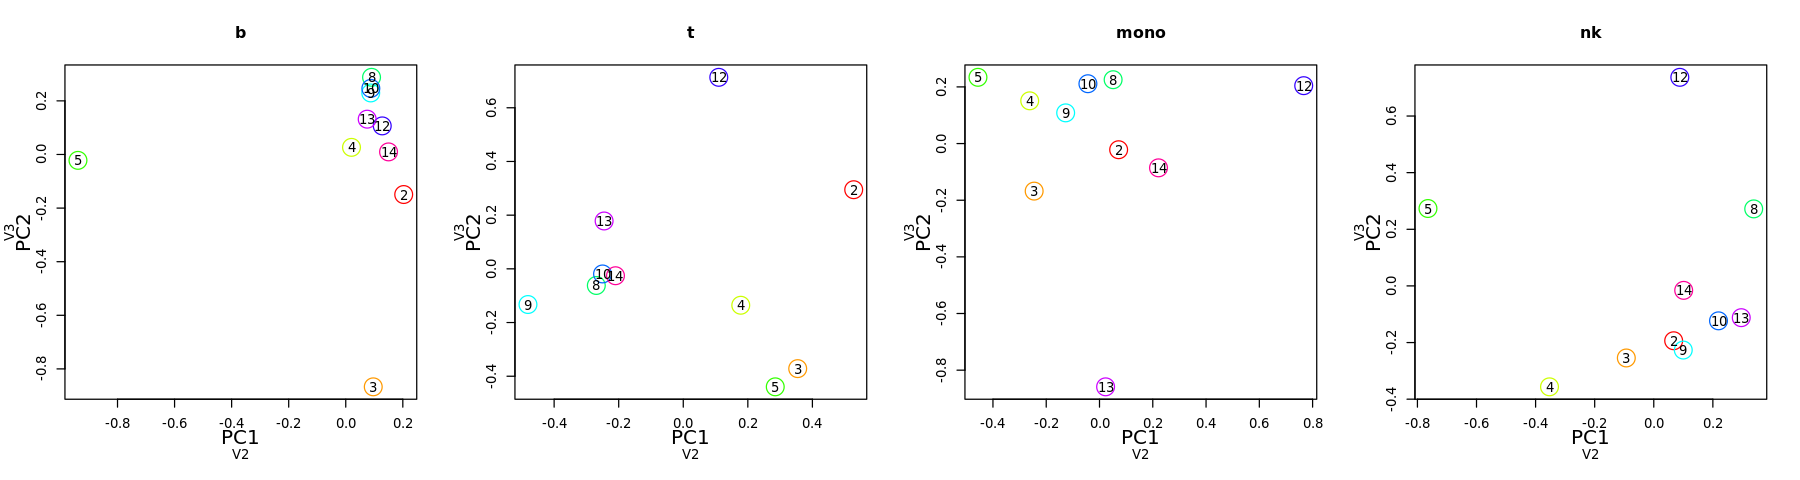

In [38]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,4))
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
pca = read.table(paste0(outfolder, "/covariates.",c, ".txt" ))
   
plot(pca[,2:3], cex = 3, main = c, col = rainbow(length(ids))) ## col1 is size factor
mtext(side = 1:2, text=c("PC1","PC2"), line=2)
text(pca[,2:3], labels = ids)
#plot(pca[,3:4], cex = 3, main = c) ## col1 is size factor
#text(pca[,3:4], labels = ids)
#mtext(side = 1:2, text=c("PC2","PC3"), line=2)    
}

In [39]:
codir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/covariates/'
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates2.",c, ".txt" )
    
make_covariates (ytxt=y, ktxt=k, outfile=x) ###recalculate original ones 
#newcov = cbind(read.table(x), read.table(paste0(codir, "4_gt_pcs")))
newcov = cbind(read.table(x),
               #read.table(paste0(codir, "age"))[-c(1,6,13),],
               #read.table(paste0(codir, "sex"))[-c(1,6,13),]*0.1, 
               read.table(paste0(codir, "4_gt_pcs"))[-c(1,6,13),])

write.table( newcov, x, col=F,row=F,sep="\t",quote=F)
txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

### Prepare vcf with Allelic counts

In [40]:
library("stringr")

In [41]:
vcf_dir  = '/nfs/lab/projects/pbmc_snATAC/pipeline/snp_array/final_vcfs/'
homedir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl/'
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/cell_type_bam/'
samples  = paste0("PBMC", ids)

In [42]:
filter_vcf = function(cell) {
        
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outdir = paste(homedir, reso, cell, "vcfs_peaksonly", sep="/")    
    system(paste("mkdir -p ",outdir  ) )   
    outvcf = paste0(outdir, "/chr",n ,'.filt.vcf')
    bed    = paste0(homedir, reso, "/",cell, "/" , cell, '.filtered.bed')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, '-s PBMC2,PBMC3,PBMC4,PBMC5,PBMC8,PBMC9,PBMC10,PBMC12,PBMC13,PBMC14','--types snps',
    "-i \'INFO/R2[0]>0.7\' | bcftools view -i \'COUNT(GT=\"het\")>1\' -o" , outvcf))
}
    }

In [43]:
reso="broad"

In [44]:
mclapply(celltypes, function(x) filter_vcf(x) , mc.cores = 20)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

In [45]:
for (cell in celltypes) {
setwd(paste(homedir, reso, cell, "vcfs_peaksonly", sep="/"))
system("bcftools concat chr1.filt.vcf chr2.filt.vcf chr3.filt.vcf chr4.filt.vcf chr5.filt.vcf chr6.filt.vcf chr7.filt.vcf chr8.filt.vcf chr9.filt.vcf chr10.filt.vcf chr11.filt.vcf chr12.filt.vcf chr13.filt.vcf chr14.filt.vcf chr15.filt.vcf chr16.filt.vcf chr17.filt.vcf chr18.filt.vcf chr19.filt.vcf chr20.filt.vcf chr21.filt.vcf chr22.filt.vcf -Oz -o full.chr.vcf.gz")
#system("awk \'{if($0 !~ /^#/) print \"chr\"$0; else print $0}\' full.vcf > full.chr.vcf")
#system('bgzip full.chr.vcf -f')
system('tabix full.chr.vcf.gz -f')
    }

In [46]:
for (cell in celltypes){
new_vcf_dir = paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )    
bam = paste0(sampdir, "PBMC", ids,"/", reso, '/pbmc', ids, "_", cell, ".bam")
writeLines(bam, paste(new_vcf_dir, 'bam.list.txt', sep="/"))
    }

In [47]:
rasqual_ase = function (cell, reso){
setwd(paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )  )
#system("rm full.ase*")   ## remove older files 
system('bash /nfs/lab/paola/rasqual/src/ASVCF/createASVCF.sh paired_end bam.list.txt full.chr.vcf.gz full.ase.filtered.vcf.gz atac')
system('tabix full.ase.filtered.vcf.gz -f')
    }

In [ ]:
mclapply(celltypes, function(x) rasqual_ase(cell =x, reso="broad"), mc.cores = 32)

### Run caQTLs

In [49]:
suppressPackageStartupMessages(library(dplyr))

In [50]:
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [51]:
rasqual_caQTL = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, outlogdir,
                         nsamples=10, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$chromosome_name[x], ":",snp_counts$range_start[x] ,"-",snp_counts$range_end[x])
outfile = paste0(outdir, "/",  snp_counts$gene_id[x])   
outlog    = paste0(outlogdir,"/",  snp_counts$gene_id[x], ".log")
    
system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', snp_counts$cis_snp_count[x] ,
'-m', snp_counts$feature_snp_count[x] , 
'-s', snp_counts$exon_starts[x],
'-e', snp_counts$exon_ends[x] , 
'-f', snp_counts$gene_id[x],            
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
#'--min-coverage-depth 6',
'>', outfile, "2>", outlog))
    
}

In [196]:
###### set parmetes here ######
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cleanup_caqtl/caqtl/broad/'
celltypes   = c("b", "t", "mono", "nk")
P           =  TRUE ## permutation? 
folder_name = 'run2_perm2_lead'
L           =  TRUE ## report only lead?
nsamples    = 10
####################################

setwd(maindir)

In [197]:
for (c in celltypes){

cat (c, "\n")
counts      = paste0( c, "/counts.",c, ".bin" )
offsets     = paste0( c, "/size_factors.",c, ".bin" )
#covariates  = paste0( c, "/covariates.",c, ".bin" )
covariates  = paste0( c, "/covariates2.",c, ".bin" )

inp = read.table(paste0( c, "/counts.",c, ".txt" ), row.names=1)
cm  = read.table(paste0( c,"/",c, ".count_matrix" ), header=T, stringsAsFactors = F)

peak_data = cm[,c(1,2,5,3,4)]
peak_data$Strand = as.integer(1)
colnames(peak_data) =  c('gene_id','chr','strand','exon_starts','exon_ends')
peak_data$exon_starts = as.character(peak_data$exon_starts)
peak_data$exon_ends = as.character(peak_data$exon_ends)

vcf_dir = paste0(c, '/vcfs_peaksonly/' )
#vcf_dir = paste0(c, '/vcfs_peaks10kb/' )
 #vcf_dir = paste0(c, '/vcfs_peaks50kb/' )  
    
system(paste0("bcftools query -f '%CHROM\\t%POS\\t%ID\\n' ", 
              vcf_dir,  "full.ase.filtered.vcf.gz > ",  vcf_dir, 'full.ase.filtered.snps'))
   
snps2           = read.table(paste0(vcf_dir, "full.ase.filtered.snps"))
colnames(snps2) = c('chr','pos','snp_id')
    
snp_counts2 = countSnpsOverlapingExons(peak_data, snps2, cis_window = 10000)
snp_counts2 = subset(snp_counts2, feature_snp_count>0 |  cis_snp_count> 0)
snp_counts_sub = subset(snp_counts2, gene_id %in% rownames(inp))

indexes =  match ( snp_counts_sub$gene_id,rownames(inp))

cat(sum(rownames(inp[indexes,])!= snp_counts_sub$gene_id), "\n")

sp = split(snp_counts_sub, snp_counts_sub$chromosome_name)

for ( n in 1:22){

chrom  = paste0("chr", n)
outdir = paste( c, folder_name , chrom, sep ="/")
system(paste('mkdir -p', outdir))
outlogdir = paste0(outdir, "/logs")
system(paste("mkdir",outlogdir ))
    
snp_counts_use = sp[[chrom]]
indexes        =  match ( snp_counts_use$gene_id,rownames(inp))

vcf_file = paste0(vcf_dir,  'full.ase.filtered.vcf.gz' )
    

mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
                                                           nsamples=nsamples, 
                                                           vcf=vcf_file, outdir=outdir, outlogdir=outlogdir ,
                                                           lead=L, permut=P) , mc.cores = 16 )
         }
    
    }

b 
0 
t 
0 
mono 
0 
nk 
0 


In [198]:
compile_results = function(n,folder_name,outdir ){
  	    chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, sep ="/")
        system(paste0("cat ", outdir,  "/* > ", c , "/", folder_name,".results_chr", n))
    }


for (c in celltypes){
    cat (c, "\n")
    tabname = paste0(c, "/Results_", folder_name, ".tsv")
    
        
 mclapply (1:22, function(x) compile_results(n=x,folder_name=folder_name,outdir=outdir))
         
        system(paste0("cat ", c , "/", folder_name,".results_chr* > ", tabname))
        system(paste0("rm ", c , "/", folder_name,".results_chr*"))
         results           = read.table(tabname, fill=T)
         colnames(results) = coln
         results           = subset(results,results$rsID !="SKIPPED")
         results$P_VAl     = pchisq(results[,11], 1, lower=F)
         write.table(results, tabname, sep="\t", quote=F)

}


b 
t 
mono 
nk 


In [199]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [200]:
df = data.frame()
for (c in celltypes) {
results       = read.table(paste0(c, "/Results_run2_all.tsv"), header=T, stringsAsFactors = F)
random        = read.table(paste0(c, "/Results_run2_perm1_lead.tsv"), header=T, stringsAsFactors = F)
random2       = read.table(paste0(c, "/Results_run2_perm2_lead.tsv"), header=T, stringsAsFactors = F)
results       = results[order(results$P_VAl),]
results_lead  = results[!duplicated(results$Feature),]
    
thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 

results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                   thresh01, sum(results_lead$flag_fdr01, na.rm=T), nrow(results_lead)))

write.table(results_lead, paste0(c, "/Results_run2_lead.tsv"),sep="\t", quote=F, row.names=F)    

}
rownames(df) = celltypes
colnames(df) = c('pval_fdr10%', 'caQTL_fdr10%', 'pval_fdr05%', 'caQTL_fdr05%','pval_fdr01%', 'caQTL_fdr01%', "tested_features")


In [213]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b,0.06096522,741,0.02332007,424,0.0021242527,128,44351
t,0.04173464,2427,0.01178464,1414,0.0001879685,402,96067
mono,0.05874312,3611,0.02086925,2230,0.0010718405,749,125154
nk,0.04330221,785,0.01709801,471,0.0006379716,118,51174


In [66]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b,0.07376231,672,0.026769599,355,0.0017164313,94,51765
t,0.03796437,1901,0.012151955,1181,0.0008051371,522,111580
mono,0.05423647,2705,0.019509807,1738,0.0011256713,641,145672
nk,0.03721710,561,0.007820383,263,0.0004624988,105,59376


### Compare with the previous data

In [76]:
library(scales)

In [243]:
rr = data.frame()

for (cc in celltypes){

res         =  read.table(paste0( cc, "/Results_run2_all.tsv"), header=T, stringsAsFactors = F)
reslead     =  read.table(paste0( cc, "/Results_run2_lead.tsv"), header=T, stringsAsFactors = F)    
res2        =  read.table(paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/', 
                                 cc, "/Results_run3_all.tsv"), header=T, stringsAsFactors = F)
res2lead        =  read.table(paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/', 
                                 cc, "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)


    
res$caQTL  = res$Feature %in% reslead$Feature[reslead$flag_fdr10  &  reslead$Ref_allele_bias<0.8 
                                              & reslead$Ref_allele_bias >0.2 & reslead$Sequencing_mapping_error_rate<0.1 ]
res        = subset(res,res$rsID !="SKIPPED")

res2$caQTL  = res2$Feature %in% res2lead$Feature[res2lead$flag_fdr10  &  res2lead$Ref_allele_bias<0.8 
                                              & res2lead$Ref_allele_bias >0.2 & res2lead$Sequencing_mapping_error_rate<0.1 ]
res2        = subset(res2,res2$rsID !="SKIPPED")

res2 = merge(res2, res[,c("Feature", "rsID", "Effect_size",'caQTL','P_VAl')], by=c("Feature", "rsID"))    


res2$minp = apply(res2[, c('P_VAl.x', 'P_VAl.y')], 1, min)

res2 = res2[order(res2$minp),]
res2 = subset(res2, caQTL.x==T | caQTL.y==T)
res2 = res2[!duplicated(res2$Feature),]
res2$signif = apply(res2, 1, function(x) paste(x['caQTL.x'], x['caQTL.y'], collaspe = ""))
res2$cell = cc    
    
rr  = rbind(rr, res2)

                     }


In [244]:
macro = rr
sp1 = split(macro, macro$cell)
sapply(sp1, function(y) sum(apply (y[,c('Effect_size.x' , 'Effect_size.y')],1, function(x) sum(x>0.5)==1)) / nrow(y) )

b         mono           nk            t 
0.0000000000 0.0005011275 0.0000000000 0.0011838990

In [245]:
colpal = c('FALSE TRUE '= 4,'TRUE FALSE '= 1,'TRUE TRUE '= 2)
tb = table(macro$signif, macro$cell)

In [246]:
tb

             
                 b mono   nk    t
  FALSE TRUE   100  492   47  408
  TRUE FALSE    25  410  110  133
  TRUE TRUE    638 3089  729 1993

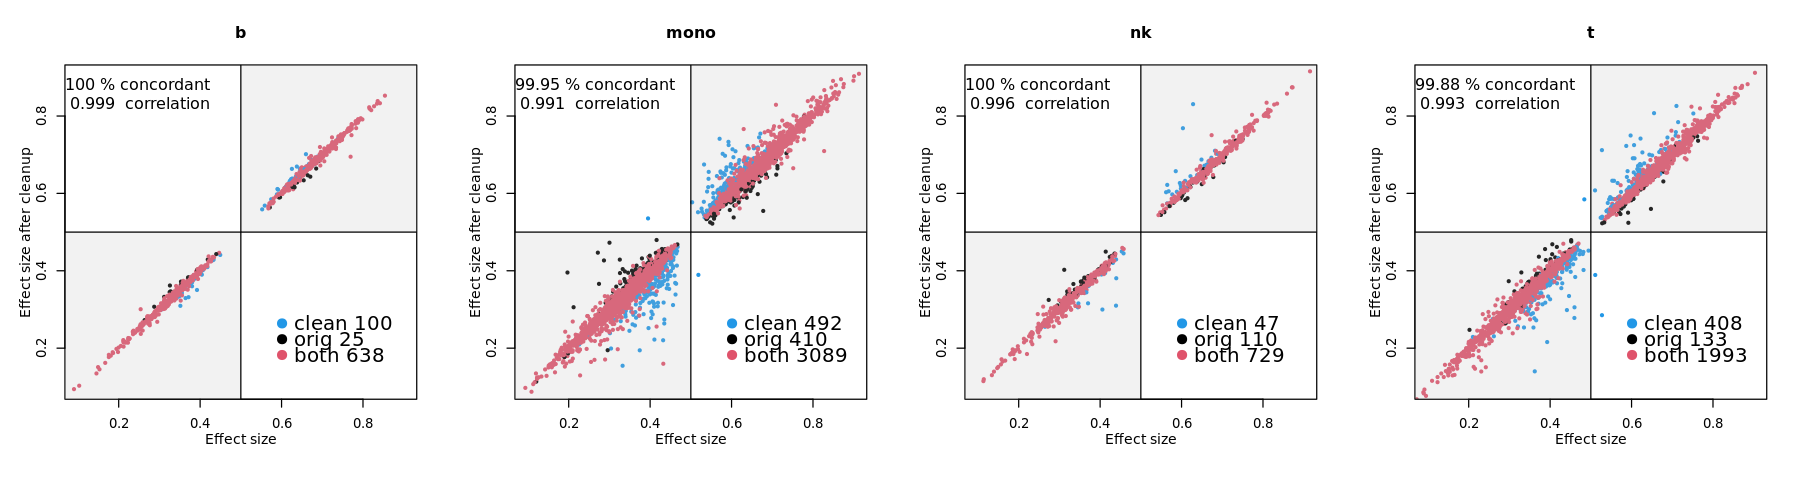

In [249]:
#par(mfrow = c(5,4),  mar = c(4,4,2,2))
par(mfrow = c(1,4))
for(i in 1:4){
tab = sp1[[i]]
    tab = tab[order(-tab$P_VAl.x),]
plot(Effect_size.y~Effect_size.x, tab , pch=19, main = names(sp1)[i],cex=0.5, xlab=NA, ylab=NA,
       xlim=c(0.1, 0.9), ylim=c(0.1, 0.9),col = colpal[tab$signif])
     mtext( "Effect size after cleanup", side = 2, cex=0.7, line=2)
           mtext( "Effect size", side=1, cex=0.7, line=2)
    
rect(0,0,0.5,0.5, col = alpha ('gray', 0.2))
rect(0.5,0.5,1,1, col = alpha ('gray', 0.2))
disc = sum(apply (tab[,c('Effect_size.x' , 'Effect_size.y')],1, function(x) sum(x>0.5)==1))  
fract = disc/nrow(tab)    
co =  round(cor.test(tab$Effect_size.x, tab$Effect_size.y)$estimate,3)
   mtext(paste(  100-(round(fract,4)*100), "% concordant \n", 
              co, " correlation"), line=-3, adj=0, cex=0.8)

  legend(x = 0.45, y=0.3, pch = 19, col = colpal, 
         legend = paste( c("clean", 'orig',"both"), tb[,i]), bty="n", inset = -0.3,
         cex = 1.5,,x.intersp = 0.2,y.intersp = 1.3 ,   )             
    }


## more stringent fdr

In [226]:
rr = data.frame()

for (cc in celltypes){

res         =  read.table(paste0( cc, "/Results_run2_all.tsv"), header=T, stringsAsFactors = F)
reslead     =  read.table(paste0( cc, "/Results_run2_lead.tsv"), header=T, stringsAsFactors = F)    
res2        =  read.table(paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/', 
                                 cc, "/Results_run3_all.tsv"), header=T, stringsAsFactors = F)
res2lead        =  read.table(paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/', 
                                 cc, "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)


    
res$caQTL  = res$Feature %in% reslead$Feature[reslead$flag_fdr05  &  reslead$Ref_allele_bias<0.8 
                                              & reslead$Ref_allele_bias >0.2 & reslead$Sequencing_mapping_error_rate<0.1 ]
res        = subset(res,res$rsID !="SKIPPED")

res2$caQTL  = res2$Feature %in% res2lead$Feature[res2lead$flag_fdr05  &  res2lead$Ref_allele_bias<0.8 
                                              & res2lead$Ref_allele_bias >0.2 & res2lead$Sequencing_mapping_error_rate<0.1 ]
res2        = subset(res2,res2$rsID !="SKIPPED")

res2 = merge(res2, res[,c("Feature", "rsID", "Effect_size",'caQTL','P_VAl')], by=c("Feature", "rsID"))    


res2$minp = apply(res2[, c('P_VAl.x', 'P_VAl.y')], 1, min)

res2 = res2[order(res2$minp),]
res2 = subset(res2, caQTL.x==T | caQTL.y==T)
res2 = res2[!duplicated(res2$Feature),]
res2$signif = apply(res2, 1, function(x) paste(x['caQTL.x'], x['caQTL.y'], collaspe = ""))
res2$cell = cc    
    
rr  = rbind(rr, res2)

                     }


In [227]:
macro = rr
sp1 = split(macro, macro$cell)
sapply(sp1, function(y) sum(apply (y[,c('Effect_size.x' , 'Effect_size.y')],1, function(x) sum(x>0.5)==1)) / nrow(y) )

b         mono           nk            t 
0.0000000000 0.0000000000 0.0000000000 0.0006397953

In [228]:
colpal = c('FALSE TRUE '= 4,'TRUE FALSE '= 1,'TRUE TRUE '= 2)
tb = table(macro$signif, macro$cell)

In [229]:
tb

             
                 b mono   nk    t
  FALSE TRUE    66  338   25  175
  TRUE FALSE    11  261   60  166
  TRUE TRUE    357 1869  441 1222

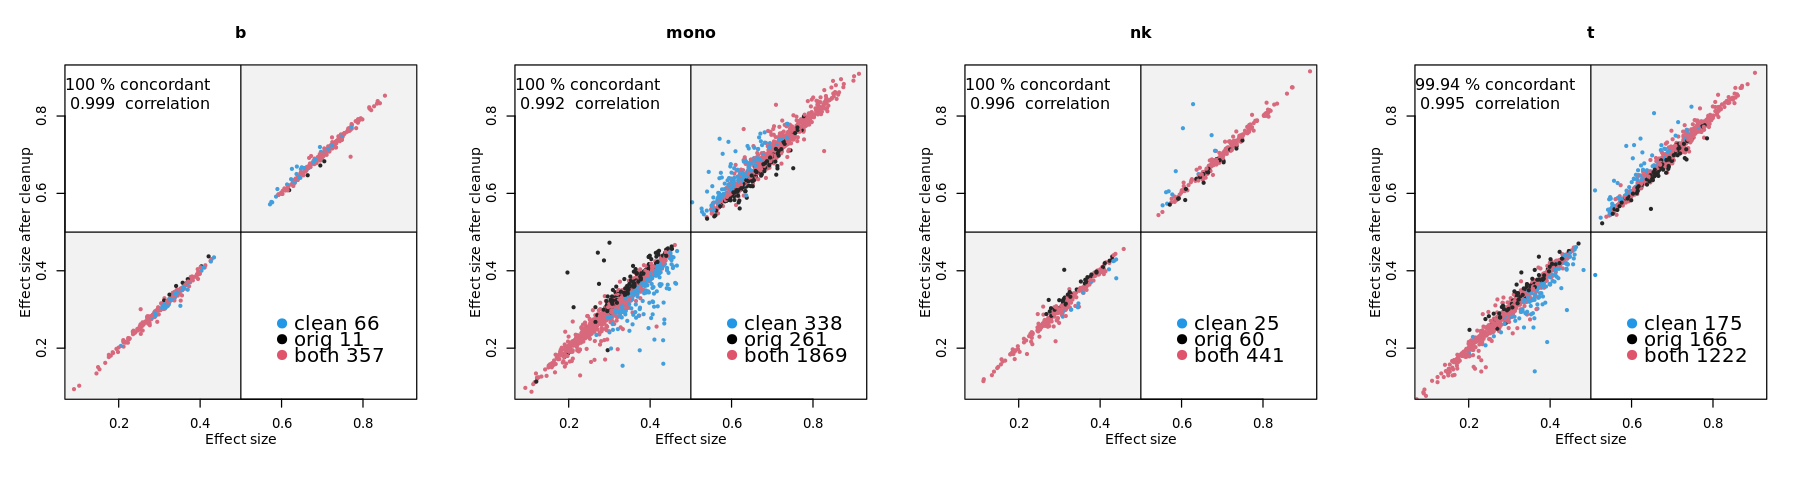

In [242]:
#par(mfrow = c(5,4),  mar = c(4,4,2,2))
par(mfrow = c(1,4))
for(i in 1:4){
tab = sp1[[i]]
plot(Effect_size.y~Effect_size.x, tab , pch=19, main = names(sp1)[i],cex=0.5, xlab=NA, ylab=NA,
       xlim=c(0.1, 0.9), ylim=c(0.1, 0.9),col = colpal[tab$signif])
     mtext( "Effect size after cleanup", side = 2, cex=0.7, line=2)
           mtext( "Effect size", side=1, cex=0.7, line=2)
    
rect(0,0,0.5,0.5, col = alpha ('gray', 0.2))
rect(0.5,0.5,1,1, col = alpha ('gray', 0.2))
disc = sum(apply (tab[,c('Effect_size.x' , 'Effect_size.y')],1, function(x) sum(x>0.5)==1))  
fract = disc/nrow(tab)    
co =  round(cor.test(tab$Effect_size.x, tab$Effect_size.y)$estimate,3)
   mtext(paste(  100-(round(fract,4)*100), "% concordant \n", 
              co, " correlation"), line=-3, adj=0, cex=0.8)

  legend(x = 0.45, y=0.3, pch = 19, col = colpal, 
         legend = paste( c("clean", 'orig',"both"), tb[,i]), bty="n", inset = -0.3,
         cex = 1.5,,x.intersp = 0.2,y.intersp = 1.3 ,   )             
    }
